# 2. INFERENCE


### 2.1 Download the data


In [1]:
!pip install -q datasets matplotlib joblib

README.md:   0%|          | 0.00/510 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/111k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9811 [00:00<?, ? examples/s]

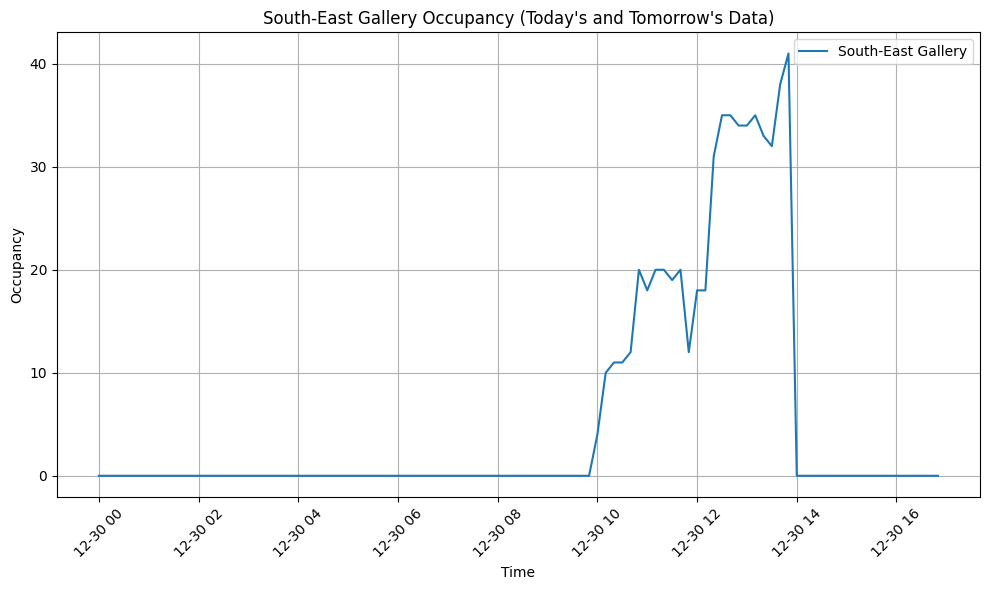

Downloaded Data (without NaN):
                     KTH Library  South-East Gallery  North Gallery  \
2024-12-30 00:00:00          0.0                 0.0            0.0   
2024-12-30 00:10:00          0.0                 0.0            0.0   
2024-12-30 00:20:00          0.0                 0.0            0.0   
2024-12-30 00:30:00          0.0                 0.0            0.0   
2024-12-30 00:40:00          0.0                 0.0            0.0   

                     South Gallery  Ångdomen  Newton  
2024-12-30 00:00:00            0.0       0.0     0.0  
2024-12-30 00:10:00            0.0       0.0     0.0  
2024-12-30 00:20:00            0.0       0.0     0.0  
2024-12-30 00:30:00            0.0       0.0     0.0  
2024-12-30 00:40:00            0.0       0.0     0.0  

Null Data (with NaN):
                     KTH Library  South-East Gallery  North Gallery  \
2024-12-30 17:00:00          NaN                 NaN            NaN   
2024-12-30 17:10:00          NaN               

In [2]:
import pandas as pd
import numpy as np
import joblib
from datasets import load_dataset
import matplotlib.pyplot as plt
from datetime import timedelta

# Step 1: Load the seating dataset
repo_name_seating = "davnas/occupancy_perc"
hf_dataset_seating = load_dataset(repo_name_seating)

# Combine all splits into a single DataFrame with appropriate data types
df_seating = pd.concat(
    [split.to_pandas().astype({'KTH Library': int, 'South-East Gallery': int, 'North Gallery': int,
                               'South Gallery': int, 'Ångdomen': int, 'Newton': int})
     for split in hf_dataset_seating.values()],
    ignore_index=True
)
df_seating.set_index('index', inplace=True)
df_seating.index = pd.to_datetime(df_seating.index)  # Ensure the index is datetime

# Resample to 10-minute intervals and fill missing data (while keeping original rounding)
df_seating_resampled = df_seating.resample('10T').mean().interpolate(method='linear').round().astype(int)

# Filter data to only include today and tomorrow
today = pd.Timestamp.today().normalize()  # Today's date without time
tomorrow_midnight = (today + timedelta(days=1)).normalize()  # Tomorrow's midnight
end_of_tomorrow = tomorrow_midnight + timedelta(days=1)  # End of tomorrow, for the full 24 hours

# Get the last available entry for today
last_valid_entry = df_seating_resampled[df_seating_resampled.index.date == today.date()].index[-1]

# Create the datetime range from the last entry until tomorrow midnight
time_range = pd.date_range(start=last_valid_entry + timedelta(minutes=10), end=end_of_tomorrow, freq='10T')

# Create a DataFrame for this time range with NaN values
nan_df = pd.DataFrame(np.nan, index=time_range, columns=df_seating_resampled.columns)

# Concatenate the original data with the NaN data (after the last valid entry until tomorrow midnight)
df_seating_combined = pd.concat([df_seating_resampled, nan_df])

# Ensure the data has the correct format, with NaN entries for after today until tomorrow midnight
df_seating_combined = df_seating_combined.sort_index()

# Filter to keep only data from today and tomorrow
df_today_tomorrow = df_seating_combined[(df_seating_combined.index >= today) & (df_seating_combined.index < end_of_tomorrow)]

# Split into downloaded data (non-NaN) and null data (NaN)
df_downloaded = df_today_tomorrow[df_today_tomorrow.notna().all(axis=1)].copy()
df_null = df_today_tomorrow[df_today_tomorrow.isna().any(axis=1)].copy()

# Recombine into the full DataFrame
df_full = pd.concat([df_downloaded, df_null]).sort_index()

# Plot the data for today and tomorrow
plt.figure(figsize=(10, 6))
plt.plot(df_full.index, df_full['South-East Gallery'], label="South-East Gallery")
plt.title("South-East Gallery Occupancy (Today's and Tomorrow's Data)")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, print the split DataFrames to check
print("Downloaded Data (without NaN):")
print(df_downloaded.head())

print("\nNull Data (with NaN):")
print(df_null.head())

print("\nFull DataFrame after recombination:")
print(df_full.head())


In [3]:
df_today_tomorrow

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton
2024-12-30 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2024-12-31 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-31 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-31 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import requests

def get_detailed_weather_forecast(latitude, longitude):
    """
    Fetches a detailed weather forecast for the remainder of the current day and the next 24 hours,
    with data points every 10 minutes created manually from hourly data.

    Parameters:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.

    Returns:
        pd.DataFrame: DataFrame containing the forecast data with 10-minute intervals.
    """
    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m"],
        "forecast_days": 2,  # Ensures today and tomorrow are covered
        "timezone": "auto",
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    # Extract hourly data
    hourly_data = data.get('hourly', {})

    if not hourly_data:
        raise ValueError("No hourly data available in the API response.")

    weather_df = pd.DataFrame(hourly_data)

    # Convert time to datetime format
    if "time" in weather_df.columns:
        weather_df["time"] = pd.to_datetime(weather_df["time"], errors="coerce")
    else:
        raise KeyError("The 'time' column is missing in the hourly weather data.")

    # Set 'time' as the index
    weather_df.set_index("time", inplace=True)

    # Create 10-minute intervals
    detailed_weather_data = []
    for i in range(len(weather_df) - 1):
        start_row = weather_df.iloc[i]
        end_row = weather_df.iloc[i + 1]
        time_start = weather_df.index[i]
        time_end = weather_df.index[i + 1]

        # Generate intermediate 10-minute data
        time_range = pd.date_range(time_start, time_end, periods=7)[1:]
        for t in time_range:
            interpolated_row = {
                "time": t,
                "temperature_2m": start_row["temperature_2m"] + (end_row["temperature_2m"] - start_row["temperature_2m"]) * (t - time_start) / (time_end - time_start),
                "precipitation": start_row["precipitation"] + (end_row["precipitation"] - start_row["precipitation"]) * (t - time_start) / (time_end - time_start),
                "wind_speed_10m": start_row["wind_speed_10m"] + (end_row["wind_speed_10m"] - start_row["wind_speed_10m"]) * (t - time_start) / (time_end - time_start),
                "wind_direction_10m": start_row["wind_direction_10m"] + (end_row["wind_direction_10m"] - start_row["wind_direction_10m"]) * (t - time_start) / (time_end - time_start),
            }
            detailed_weather_data.append(interpolated_row)

    # Convert to DataFrame
    detailed_weather_df = pd.DataFrame(detailed_weather_data)
    detailed_weather_df.set_index("time", inplace=True)

    # Debug outputs
    print("Index type:", detailed_weather_df.index.dtype)
    print("Columns:", detailed_weather_df.columns)

    return detailed_weather_df

# Parameters
latitude, longitude = 59.3293, 18.0686  # Stockholm coordinates

# Get weather data for today and tomorrow, interpolated to 10-minute intervals
weather_data = get_detailed_weather_forecast(latitude, longitude)

# Print the merged and interpolated weather data for today and tomorrow
weather_data



Index type: datetime64[ns]
Columns: Index(['temperature_2m', 'precipitation', 'wind_speed_10m',
       'wind_direction_10m'],
      dtype='object')


,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
time,,,,
2024-12-30 00:10:00,8.133333,0.466667,37.583333,242.833333
2024-12-30 00:20:00,8.166667,0.433333,37.766667,244.666667
2024-12-30 00:30:00,8.200000,0.400000,37.950000,246.500000
2024-12-30 00:40:00,8.233333,0.366667,38.133333,248.333333
2024-12-30 00:50:00,8.266667,0.333333,38.316667,250.166667
...,...,...,...,...
2024-12-31 22:20:00,-0.433333,1.100000,18.000000,120.666667
2024-12-31 22:30:00,-0.300000,1.150000,19.450000,124.000000
2024-12-31 22:40:00,-0.166667,1.200000,20.900000,127.333333


In [5]:
# Step 2: Load the academic calendar dataset
repo_name_calendar = "andreitut/kth-academic-scraper"
hf_dataset_calendar = load_dataset(repo_name_calendar)

# Convert the calendar dataset to a DataFrame
df_calendar = pd.DataFrame(hf_dataset_calendar['train'])
df_calendar['Date'] = pd.to_datetime(df_calendar['Date'])

# Expand the calendar dataset to match the minute-level resolution
df_calendar_expanded = df_calendar.set_index('Date').reindex(df_seating_resampled.index.normalize(), method='ffill').reset_index()
df_calendar_expanded.rename(columns={'index': 'Date'}, inplace=True)
df_calendar_expanded

,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
0,2024-12-09,2024,344,1,29,Normal
1,2024-12-09,2024,344,1,29,Normal
2,2024-12-09,2024,344,1,29,Normal
3,2024-12-09,2024,344,1,29,Normal
4,2024-12-09,2024,344,1,29,Normal
...,...,...,...,...,...,...
3012,2024-12-30,2024,365,1,8,Holyday
3013,2024-12-30,2024,365,1,8,Holyday
3014,2024-12-30,2024,365,1,8,Holyday
3015,2024-12-30,2024,365,1,8,Holyday


In [6]:
repo_name = "davnas/date_kth"

# Load the dataset from Hugging Face
hf_dataset = load_dataset(repo_name)

df_opening = pd.concat(
    [split.to_pandas() for split in hf_dataset.values()],
    ignore_index=True
)

# Set the index if the 'index' column exists
if 'index' in df_opening.columns:
    df_opening.set_index('index', inplace=True)

# Display the DataFrame
print(df_opening)


         date        day  opening_hour  closing_hour  is_open
0  2024-12-09     Monday            18            21        1
1  2024-12-10    Tuesday            10            21        1
2  2024-12-11  Wednesday             8            21        1
3  2024-12-12   Thursday             8            21        1
4  2024-12-13     Friday             8            18        1
5  2024-12-14   Saturday             0             0        0
6  2024-12-15     Sunday             0             0        0
7  2024-12-16     Monday            10            21        1
8  2024-12-17    Tuesday            10            21        1
9  2024-12-18  Wednesday             8            21        1
10 2024-12-19   Thursday             8            21        1
11 2024-12-20     Friday             8            19        1
12 2024-12-21   Saturday             0             0        0
13 2024-12-22     Sunday             0             0        0
14 2024-12-23     Monday            10            14        1
15 2024-

### 2.2 Merge the Data


In [7]:
# Step 3: Merge the seating data with the expanded academic calendar
merged_seating_calendar = pd.merge_asof(
    df_null.sort_index(),
    df_calendar_expanded.sort_values('Date'),
    left_index=True,
    right_on='Date'
)
# Visualize Step 3: Merged seating and calendar data
print("Step 3: Merged seating data with academic calendar")

merged_seating_calendar

Step 3: Merged seating data with academic calendar


,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
2024-12-30 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday
2024-12-30 17:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday
2024-12-30 17:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday
2024-12-30 17:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday
2024-12-30 17:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday
2024-12-31 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday
2024-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday
2024-12-31 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,2024,365,1,8,Holyday


In [8]:
# Merge historical weather data with the merged dataset
merge_seat_academic_weather = pd.merge_asof(
    merged_seating_calendar.sort_index(),
    weather_data.sort_index(),
    left_index=True,
    right_index=True,
    direction='forward'
)
merge_seat_academic_weather.drop(columns=['Date', 'Year'], inplace=True)
merge_seat_academic_weather

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
2024-12-30 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,1.50,0.0,15.500000,258.000000
2024-12-30 17:10:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,1.45,0.0,15.433333,257.166667
2024-12-30 17:20:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,1.40,0.0,15.366667,256.333333
2024-12-30 17:30:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,1.35,0.0,15.300000,255.500000
2024-12-30 17:40:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,1.30,0.0,15.233333,254.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,NaN,NaN,NaN,NaN
2024-12-31 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,NaN,NaN,NaN,NaN
2024-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,NaN,NaN,NaN,NaN
2024-12-31 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,365,1,8,Holyday,NaN,NaN,NaN,NaN


In [ ]:
# Convert the 'date' column in df_opening to datetime to match the index of merge_seat_academic_weather
df_opening['date'] = pd.to_datetime(df_opening['date'])

# Merge on the date index while ensuring time-specific data aligns properly
merged_final = pd.merge_asof(
    merge_seat_academic_weather.reset_index(),
    df_opening,
    left_on='index',
    right_on='date',
    direction='backward'
).set_index('index')

# Drop unnecessary columns if needed (like duplicate 'date' column)
merged_final.drop(columns=['date'], inplace=True)

# Display the resulting DataFrame
print(merged_final)
#merged_final.to_csv('merged_final.csv')

                     KTH Library  South-East Gallery  North Gallery  \
index                                                                 
2024-12-30 17:00:00          NaN                 NaN            NaN   
2024-12-30 17:10:00          NaN                 NaN            NaN   
2024-12-30 17:20:00          NaN                 NaN            NaN   
2024-12-30 17:30:00          NaN                 NaN            NaN   
2024-12-30 17:40:00          NaN                 NaN            NaN   
...                          ...                 ...            ...   
2024-12-31 23:10:00          NaN                 NaN            NaN   
2024-12-31 23:20:00          NaN                 NaN            NaN   
2024-12-31 23:30:00          NaN                 NaN            NaN   
2024-12-31 23:40:00          NaN                 NaN            NaN   
2024-12-31 23:50:00          NaN                 NaN            NaN   

                     South Gallery  Ångdomen  Newton  Day of Year  \
index  

### 2.3 MIT

In [10]:
df = merged_final.copy()
# Standardize the values by removing leading/trailing whitespace and converting to lowercase
df['Event'] = df['Event'].str.strip().str.lower()

# Update the mapping to match the standardized values
event_mapping = {
    'normal': 0,
    'holyday': 1,
    're-exam': 2,
    'self-study': 3
}

# Remap the 'Event' column
df['Event'] = df['Event'].map(event_mapping)

# Verify the changes
print(df['Event'].head())
df_resampled = df.copy()

index
2024-12-30 17:00:00    1
2024-12-30 17:10:00    1
2024-12-30 17:20:00    1
2024-12-30 17:30:00    1
2024-12-30 17:40:00    1
Name: Event, dtype: int64


In [11]:
# Ensure the index is a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Update 'is_open' column based on opening and closing hours
df_resampled['is_open'] = ((df_resampled.index.hour >= df_resampled['opening_hour']) & (df_resampled.index.hour < df['closing_hour'])).astype(int)
df_resampled = df_resampled[:-10]
#df_resampled.to_csv('df_resampled.csv')

In [12]:
df_future = df_resampled.copy()

### 2.4 Download Model do prediction

In [13]:
print(df_future)

                     KTH Library  South-East Gallery  North Gallery  \
index                                                                 
2024-12-30 17:00:00          NaN                 NaN            NaN   
2024-12-30 17:10:00          NaN                 NaN            NaN   
2024-12-30 17:20:00          NaN                 NaN            NaN   
2024-12-30 17:30:00          NaN                 NaN            NaN   
2024-12-30 17:40:00          NaN                 NaN            NaN   
...                          ...                 ...            ...   
2024-12-31 21:30:00          NaN                 NaN            NaN   
2024-12-31 21:40:00          NaN                 NaN            NaN   
2024-12-31 21:50:00          NaN                 NaN            NaN   
2024-12-31 22:00:00          NaN                 NaN            NaN   
2024-12-31 22:10:00          NaN                 NaN            NaN   

                     South Gallery  Ångdomen  Newton  Day of Year  \
index  

In [14]:
df_future.reset_index(inplace=True)

df_future.rename(columns={
    'index': 'ds'
}, inplace=True)


#### download the model

In [15]:
import os 
import joblib
from huggingface_hub import login, hf_hub_download

# Ottieni il token dai secrets di GitHub
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")


# Verifica che il token sia definito
if not HUGGINGFACE_TOKEN:
    raise ValueError("HUGGINGFACE_TOKEN non è stato definito. Assicurati che sia passato come variabile d'ambiente.")



login(token=HUGGINGFACE_TOKEN)

In [16]:

# Set your repository name
repo_name = "davnas/library_model"  # Replace with your repository name

# List of model filenames
locations = ["KTH Library", "South-East Gallery", "North Gallery", "South Gallery", "Ångdomen", "Newton"]
model_filenames = [f"prophet_model_{location.replace(' ', '_')}.joblib" for location in locations]

# Download and load each model
loaded_models = {}
for model_filename in model_filenames:
    try:
        model_path = hf_hub_download(
            repo_id=repo_name,
            filename=model_filename
        )
        loaded_models[model_filename] = joblib.load(model_path)
        print(f"Model {model_filename} downloaded and loaded successfully.")
    except Exception as e:
        print(f"Failed to download or load model {model_filename}: {e}")

# Now `loaded_models` is a dictionary containing all the loaded Prophet models


prophet_model_KTH_Library.joblib:   0%|          | 0.00/552k [00:00<?, ?B/s]

Importing plotly failed. Interactive plots will not work.


Model prophet_model_KTH_Library.joblib downloaded and loaded successfully.


prophet_model_South-East_Gallery.joblib:   0%|          | 0.00/552k [00:00<?, ?B/s]

Model prophet_model_South-East_Gallery.joblib downloaded and loaded successfully.


prophet_model_North_Gallery.joblib:   0%|          | 0.00/552k [00:00<?, ?B/s]

Model prophet_model_North_Gallery.joblib downloaded and loaded successfully.


prophet_model_South_Gallery.joblib:   0%|          | 0.00/552k [00:00<?, ?B/s]

Model prophet_model_South_Gallery.joblib downloaded and loaded successfully.


prophet_model_Ãngdomen.joblib:   0%|          | 0.00/552k [00:00<?, ?B/s]

Model prophet_model_Ångdomen.joblib downloaded and loaded successfully.


prophet_model_Newton.joblib:   0%|          | 0.00/552k [00:00<?, ?B/s]

Model prophet_model_Newton.joblib downloaded and loaded successfully.


In [17]:
#df_future.info()

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'locations' is the list of rooms you want to predict for
locations = ['KTH Library','North Gallery', 'South-East Gallery', 'South Gallery', 'Ångdomen', 'Newton']
total_capacity = 100


In [19]:
df_future.columns

Index(['ds', 'KTH Library', 'South-East Gallery', 'North Gallery',
       'South Gallery', 'Ångdomen', 'Newton', 'Day of Year', 'Day of Week',
       'Days Until Exam', 'Event', 'temperature_2m', 'precipitation',
       'wind_speed_10m', 'wind_direction_10m', 'day', 'opening_hour',
       'closing_hour', 'is_open'],
      dtype='object')

In [20]:
# Create features for proximity to opening/closing times
def calculate_time_features(row):
    if row['is_open'] == 0:
        return 0, 0

    time_decimal = row['time_decimal']
    opening_hour = row['opening_hour']
    closing_hour = row['closing_hour']

    # Time since opening (in hours)
    time_since_opening = max(0, time_decimal - opening_hour)
    # Time until closing (in hours)
    time_until_closing = max(0, closing_hour - time_decimal)

    return time_since_opening, time_until_closing

In [21]:
# Dictionary to store predictions for all locations
predictions_dict = {}

# Iterate through each location
for location in locations:
    # Ensure the model for this location is available
    model_key = f"prophet_model_{location.replace(' ', '_')}.joblib"
    if model_key not in loaded_models:
        print(f"Model for {location} not found. Skipping...")
        continue

    # Ensure the location column exists in df_future
    if location in df_future.columns:
        # Filter the data for the current location
        df_location = df_future[['ds', location, 'Day of Year', 'Day of Week', 'Days Until Exam', 'is_open',
                                 'opening_hour', 'closing_hour', 'temperature_2m', 'precipitation', 'wind_speed_10m']].copy()

        # Rename columns for compatibility
        df_location.rename(columns={
            location: 'y',
            'Day of Year': 'DayOfYear',
            'Day of Week': 'DayOfWeek',
            'Days Until Exam': 'DaysUntilExam'
        }, inplace=True)

        # Add time-based features
        df_location['hour'] = df_location['ds'].dt.hour
        df_location['minute'] = df_location['ds'].dt.minute
        df_location['time_decimal'] = df_location['hour'] + df_location['minute'] / 60

        # Add new time-based features for proximity to opening/closing times
        df_location[['time_since_opening', 'time_until_closing']] = df_location.apply(
            calculate_time_features, axis=1, result_type='expand'
        )

        # Prepare the future dataframe for predictions
        future_location = df_location[['ds']].copy()
        future_location['cap'] = total_capacity
        future_location['floor'] = 0

        # Add time-based features to the future DataFrame
        future_location['hour'] = future_location['ds'].dt.hour
        future_location['minute'] = future_location['ds'].dt.minute
        future_location['time_decimal'] = future_location['hour'] + future_location['minute'] / 60

        # Add all regressors from the test set
        for regressor in ['DayOfYear', 'DayOfWeek', 'DaysUntilExam', 'temperature_2m',
                          'precipitation', 'wind_speed_10m', 'is_open', 'opening_hour', 'closing_hour']:
            future_location[regressor] = df_location[regressor]

        # Calculate time features for future data
        future_location[['time_since_opening', 'time_until_closing']] = future_location.apply(
            calculate_time_features, axis=1, result_type='expand'
        )

        # Use the loaded model for predictions
        loaded_model = loaded_models[model_key]
        forecast_location = loaded_model.predict(future_location)

        # Apply strict rules for opening/closing times
        forecast_location['yhat'] = np.where(future_location['is_open'] == 0, 0,
                                             np.where(future_location['time_since_opening'] == 0, 0,
                                             np.where(future_location['time_until_closing'] == 0, 0,
                                             np.clip(forecast_location['yhat'], 0, 100))))

        forecast_location['yhat_lower'] = np.where(future_location['is_open'] == 0, 0,
                                                   np.where(future_location['time_since_opening'] == 0, 0,
                                                   np.where(future_location['time_until_closing'] == 0, 0,
                                                   np.clip(forecast_location['yhat_lower'], 0, 100))))

        forecast_location['yhat_upper'] = np.where(future_location['is_open'] == 0, 0,
                                                   np.where(future_location['time_since_opening'] == 0, 0,
                                                   np.where(future_location['time_until_closing'] == 0, 0,
                                                   np.clip(forecast_location['yhat_upper'], 0, 100))))

        # Store the forecast for the current location
        predictions_dict[location] = forecast_location
    else:
        print(f"Location column '{location}' not found in the data.")


In [22]:
# Now, predictions_dict contains the predictions for all locations
# Example: Access predictions for KTH Library
#forecast_KTH_Library = predictions_dict["KTH Library"]

In [ ]:
# Initialize an empty DataFrame to hold the combined data
combined_predictions = pd.DataFrame()

# Iterate through each location and add its predictions to the combined DataFrame
for location, forecast_df in predictions_dict.items():
    # Extract the `ds` and `yhat` columns and rename `yhat` to the location name
    location_forecast = forecast_df[['ds', 'yhat']].copy()
    location_forecast.rename(columns={'yhat': location}, inplace=True)

    # Convert predictions to integers
    location_forecast[location] = location_forecast[location].astype(int)

    # Merge this location's predictions with the combined DataFrame
    if combined_predictions.empty:
        combined_predictions = location_forecast
    else:
        combined_predictions = pd.merge(combined_predictions, location_forecast, on='ds')

# Display the final combined DataFrame
combined_predictions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ds                  176 non-null    datetime64[ns]
 1   KTH Library         176 non-null    int64         
 2   North Gallery       176 non-null    int64         
 3   South-East Gallery  176 non-null    int64         
 4   South Gallery       176 non-null    int64         
 5   Ångdomen            176 non-null    int64         
 6   Newton              176 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 9.8 KB


## 2.5 Combining the past and future

In [24]:
df_past = df_downloaded.copy()
df_past.reset_index(inplace=True)
df_past.rename(columns={
    'index': 'ds'
}, inplace=True)
df_past['prediction'] = 0

df_past

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2024-12-30 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2024-12-30 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2024-12-30 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2024-12-30 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2024-12-30 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
97,2024-12-30 16:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
98,2024-12-30 16:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
99,2024-12-30 16:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
100,2024-12-30 16:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0


In [25]:
df_future = combined_predictions.copy()
df_future['prediction'] = 1
df_future

,ds,KTH Library,North Gallery,South-East Gallery,South Gallery,Ångdomen,Newton,prediction
0,2024-12-30 17:00:00,0,0,0,0,0,0,1
1,2024-12-30 17:10:00,0,0,0,0,0,0,1
2,2024-12-30 17:20:00,0,0,0,0,0,0,1
3,2024-12-30 17:30:00,0,0,0,0,0,0,1
4,2024-12-30 17:40:00,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
171,2024-12-31 21:30:00,0,0,0,0,0,0,1
172,2024-12-31 21:40:00,0,0,0,0,0,0,1
173,2024-12-31 21:50:00,0,0,0,0,0,0,1
174,2024-12-31 22:00:00,0,0,0,0,0,0,1


In [26]:
df_full = pd.concat([df_past, df_future])
df_full

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2024-12-30 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2024-12-30 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2024-12-30 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2024-12-30 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2024-12-30 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
171,2024-12-31 21:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1
172,2024-12-31 21:40:00,0.0,0.0,0.0,0.0,0.0,0.0,1
173,2024-12-31 21:50:00,0.0,0.0,0.0,0.0,0.0,0.0,1
174,2024-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1


## 2.6 Plotting and Pushing

In [27]:
from datetime import datetime

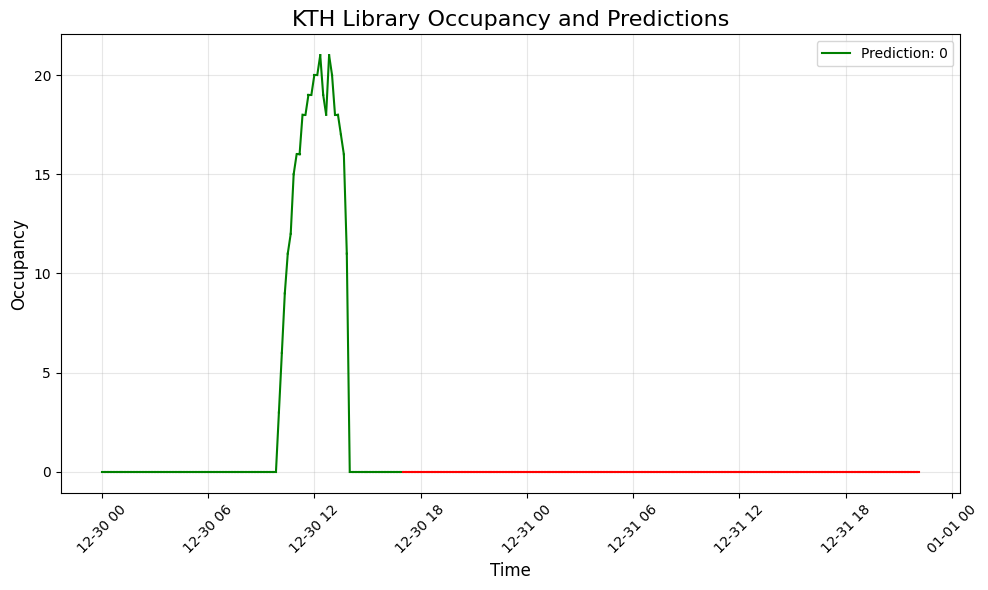

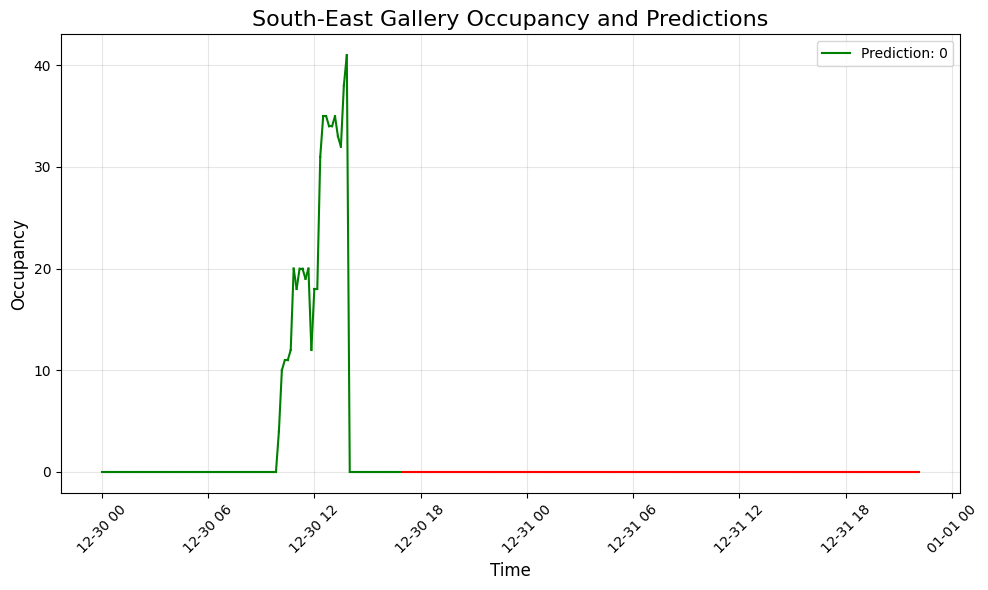

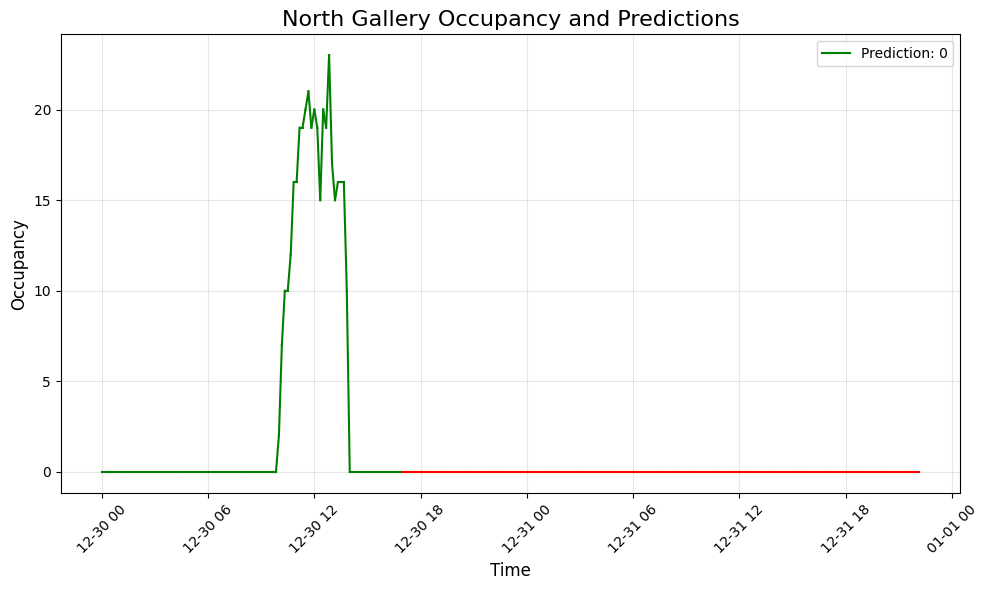

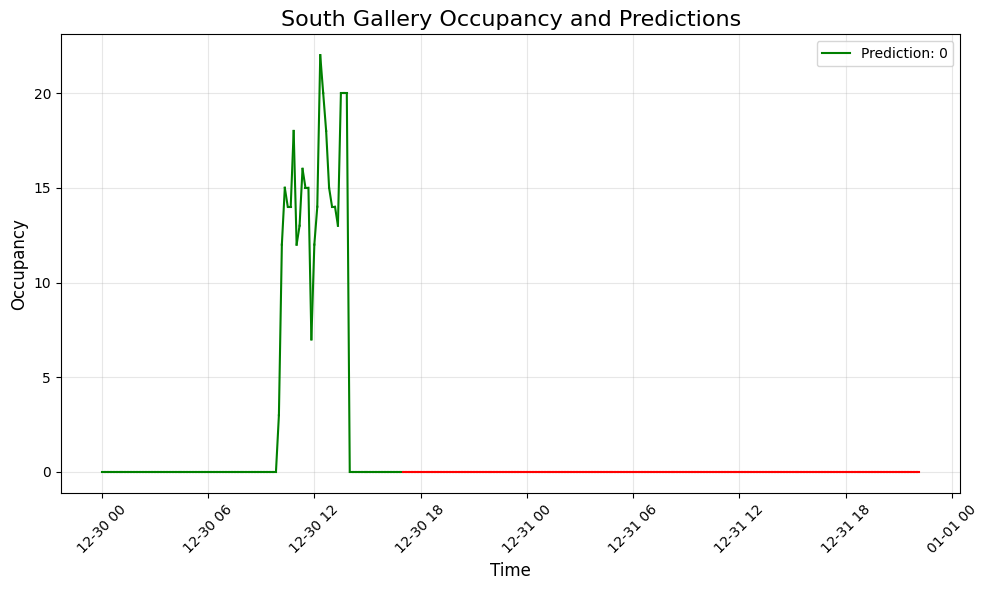

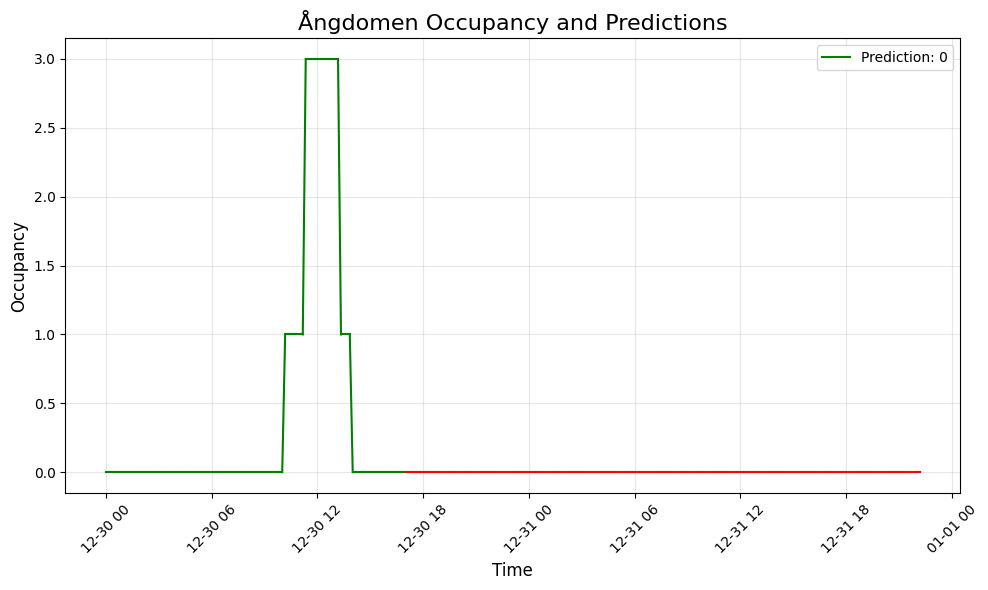

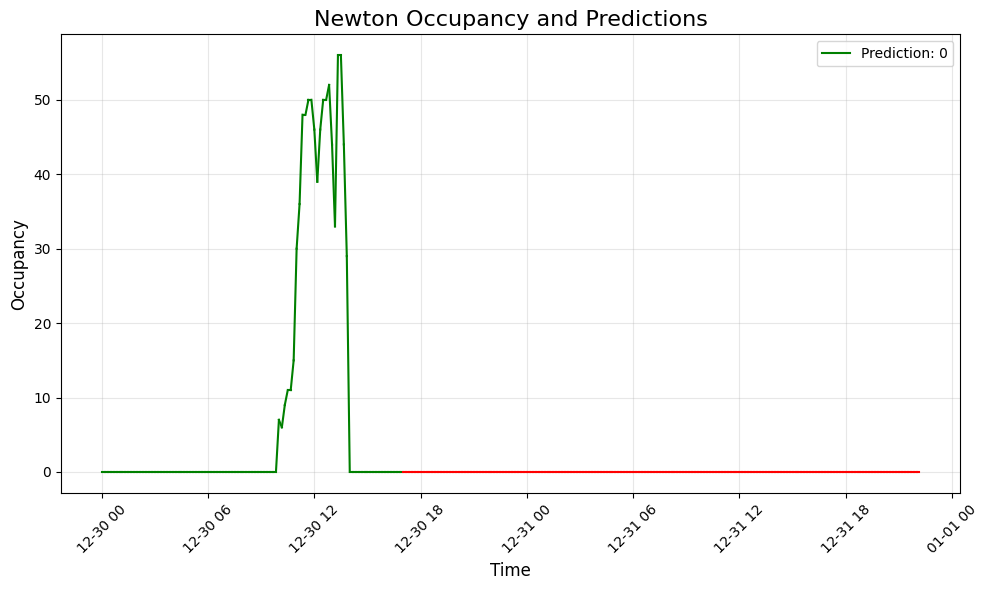

In [28]:
# Ensure the 'ds' column exists and is datetime
if 'ds' not in df_full.columns:
    raise KeyError("'ds' column is missing from the DataFrame.")

# Plot each location in a separate figure
locations = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']

for location in locations:
    plt.figure(figsize=(10, 6))

    # Iterate through the DataFrame rows and plot segments based on prediction
    for i in range(len(df_full) - 1):
        color = 'green' if df_full['prediction'].iloc[i] == 0 else 'red'
        plt.plot(
            df_full['ds'].iloc[i:i+2],  # X-axis
            df_full[location].iloc[i:i+2],  # Y-axis
            color=color, label=f'Prediction: {df_full["prediction"].iloc[i]}' if i == 0 else ""
        )

    plt.title(f"{location} Occupancy and Predictions", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Occupancy", fontsize=12)
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show each plot
    plt.show()

In [29]:
# Filter the DataFrame for today's date only
today_date = pd.Timestamp.today().normalize()
df_today = df_full[df_full['ds'].dt.date == today_date.date()].copy()


In [30]:
# Resample the DataFrame to 30-minute intervals
df_today_resampled = df_today.resample('30T', on='ds').mean().reset_index()
# Define the time range
start_time = pd.Timestamp(today_date.date()) + pd.Timedelta(hours=7, minutes=30)
end_time = pd.Timestamp(today_date.date()) + pd.Timedelta(hours=21, minutes=30)

# Filter the DataFrame in place for the specified time range
df_today_resampled = df_today_resampled[
    (df_today_resampled['ds'] >= start_time) & (df_today_resampled['ds'] <= end_time)
]
df_today_resampled



,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
15,2024-12-30 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
16,2024-12-30 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
17,2024-12-30 08:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
18,2024-12-30 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
19,2024-12-30 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20,2024-12-30 10:00:00,6.000000,8.333333,6.333333,10.000000,0.666667,7.333333,0.0
21,2024-12-30 10:30:00,12.666667,14.333333,12.666667,15.333333,1.000000,12.333333,0.0
22,2024-12-30 11:00:00,16.666667,19.333333,18.000000,13.666667,1.666667,38.000000,0.0
23,2024-12-30 11:30:00,18.666667,17.000000,20.000000,12.333333,3.000000,49.333333,0.0
24,2024-12-30 12:00:00,20.333333,22.333333,18.000000,16.000000,3.000000,43.666667,0.0


In [31]:

# Convert all occupancy values to integers
occupancy_columns = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']
df_today_resampled[occupancy_columns] = df_today_resampled[occupancy_columns].fillna(0).astype(int)

In [32]:
# Add the required columns for CommitTime and Time
current_time = datetime.now()

commit_time = (current_time + timedelta(hours=1)).strftime("%Y-%m-%d %H:%M:%S")
df_today_resampled['CommitTime'] = commit_time
df_today_resampled['Time'] = df_today_resampled['ds'].dt.strftime('%H:%M')

# Rename columns to match the required format
df_today_resampled = df_today_resampled.rename(columns={
    'KTH Library': 'Occupancy_main',
    'South-East Gallery': 'Occupancy_southEast',
    'North Gallery': 'Occupancy_north',
    'South Gallery': 'Occupancy_south',
    'Ångdomen': 'Occupancy_angdomen',
    'Newton': 'Occupancy_newton'
})

# Reorder columns
df_today_resampled = df_today_resampled[
    ['CommitTime', 'Time', 'Occupancy_main', 'Occupancy_southEast', 'Occupancy_north',
     'Occupancy_south', 'Occupancy_angdomen', 'Occupancy_newton']
]



In [33]:
df_today_resampled

,CommitTime,Time,Occupancy_main,Occupancy_southEast,Occupancy_north,Occupancy_south,Occupancy_angdomen,Occupancy_newton
15,2024-12-30 17:59:10,07:30,0,0,0,0,0,0
16,2024-12-30 17:59:10,08:00,0,0,0,0,0,0
17,2024-12-30 17:59:10,08:30,0,0,0,0,0,0
18,2024-12-30 17:59:10,09:00,0,0,0,0,0,0
19,2024-12-30 17:59:10,09:30,0,0,0,0,0,0
20,2024-12-30 17:59:10,10:00,6,8,6,10,0,7
21,2024-12-30 17:59:10,10:30,12,14,12,15,1,12
22,2024-12-30 17:59:10,11:00,16,19,18,13,1,38
23,2024-12-30 17:59:10,11:30,18,17,20,12,3,49
24,2024-12-30 17:59:10,12:00,20,22,18,16,3,43


In [34]:
# Save to CSV
df_today_resampled.to_csv('occupancy_today.csv', index=False)

# Display the first few rows of the DataFrame
print(df_today_resampled.tail())

             CommitTime   Time  Occupancy_main  Occupancy_southEast  \
39  2024-12-30 17:59:10  19:30               0                    0   
40  2024-12-30 17:59:10  20:00               0                    0   
41  2024-12-30 17:59:10  20:30               0                    0   
42  2024-12-30 17:59:10  21:00               0                    0   
43  2024-12-30 17:59:10  21:30               0                    0   

    Occupancy_north  Occupancy_south  Occupancy_angdomen  Occupancy_newton  
39                0                0                   0                 0  
40                0                0                   0                 0  
41                0                0                   0                 0  
42                0                0                   0                 0  
43                0                0                   0                 0  


In [35]:
import pandas as pd


csv_file_path = "occupancy_today.csv"


from huggingface_hub import HfApi, HfFolder

# Hugging Face token and repository details
repo_name = "davnas/library-occupancy"  # Replace with your repository name
#csv_file_path = "data.csv"  # Replace with your CSV file path

# Authenticate using the token
HfFolder.save_token(HUGGINGFACE_TOKEN)
api = HfApi()

# Upload the CSV file
api.upload_file(
    path_or_fileobj=csv_file_path,
    path_in_repo="data_2.csv",  # The name of the file in the repository
    repo_id=repo_name,
    repo_type="dataset",  # Indicates this is a dataset repository
    token=HUGGINGFACE_TOKEN
)

print(f"CSV file successfully uploaded to Hugging Face repository: {repo_name}")



CSV file successfully uploaded to Hugging Face repository: davnas/library-occupancy
